In [0]:
%tensorflow_version 2.x

In [0]:
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds


In [3]:
(train_ds, test_ds), ds_info = tfds.load(
    'lfw',
    as_supervised=True,
    with_info=True,
    split=['train[:80%]', 'train[80%:]'],
)

Shuffling and writing examples to /root/tensorflow_datasets/lfw/0.1.0.incompleteS1OSPR/lfw-train.tfrecord



Dataset lfw downloaded and prepared to /root/tensorflow_datasets/lfw/0.1.0. Subsequent calls will reuse this data.


In [0]:
n = ds_info.splits['train'].num_examples

Constrastive Loss


---






$$L=\frac{1}{2}\cdot(z \cdot d^2 + (1-z) \cdot (\max\{0,M-d\})^2)$$


---


In [0]:
MARGIN = 20.0

def contrastive_loss(embeddings, labels, margin=MARGIN):
    batch_size = embeddings.shape[0]
    embeddings_1 = embeddings[:batch_size//2, :]
    embeddings_2 = embeddings[batch_size//2:, :]
    labels_1 = labels[:batch_size//2]
    labels_2 = labels[batch_size//2:]

    d_squared = tf.reduce_sum(tf.square(embeddings_1 - embeddings_2), axis=1)
    d =  tf.sqrt(d_squared)
    z = tf.cast(labels_1 == labels_2, tf.float32)
    
    return tf.reduce_mean(z * d**2 + (1-z) * tf.maximum(0, margin - d)**2)

In [0]:
def preprocess(label, image):
    return label, tf.cast(image, tf.float32) / 255.

In [0]:
BATCH_SIZE = 64
NUM_EPOCHS = 16

train_ds = train_ds.map(preprocess)
train_ds = train_ds.shuffle(np.ceil(n/2))
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)

test_ds = test_ds.shuffle(np.ceil(n/2))
test_ds = test_ds.map(preprocess)
test_ds = test_ds.batch(BATCH_SIZE, drop_remainder=True)

In [0]:
EMB_SIZE = 64

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(EMB_SIZE, activation=None),
])

In [0]:
LEARNING_RATE = 0.001
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

In [10]:
%%time

for iteration, (labels, images) in enumerate(train_ds):
    
    # Forward
    with tf.GradientTape() as tape:
        embs = model(images)
        loss_value = contrastive_loss(embs, labels)
        
    # Backward
    grads = tape.gradient(loss_value, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))

    if iteration % 200 == 0:
        print('[{}] Loss: {}'.format(iteration, loss_value.numpy()))

[0] Loss: 385.52734375
[200] Loss: 0.3439542055130005
[400] Loss: 0.0
[600] Loss: 0.0
[800] Loss: 139.75457763671875
[1000] Loss: 0.12063955515623093
[1200] Loss: 0.3883694112300873
[1400] Loss: 2.7079410552978516
[1600] Loss: 0.0
[1800] Loss: 3.0546929836273193
[2000] Loss: 0.2902388870716095
[2200] Loss: 0.0478639118373394
[2400] Loss: 0.0
[2600] Loss: 0.0
CPU times: user 11min 53s, sys: 6min 33s, total: 18min 27s
Wall time: 22min 40s


In [0]:
def load_and_prepare_image(fpath):
    import imageio
    from skimage.transform import resize
    img = imageio.imread(fpath, pilmode="RGB")
    img = img.astype(np.float32)/255
    img = resize(img, (250, 250, 3), mode='reflect', anti_aliasing=True)
    img = np.reshape(img, (250, 250, 3))
    return img


In [0]:
import matplotlib.pyplot as plt

In [0]:
img_a1 = load_and_prepare_image('https://upload.wikimedia.org/wikipedia/commons/thumb/a/a9/Noam_Chomsky_portrait_2017.jpg/1200px-Noam_Chomsky_portrait_2017.jpg')
img_a2 = load_and_prepare_image('https://upload.wikimedia.org/wikipedia/commons/thumb/7/76/Noam_Chomsky_portrait_2015.jpg/1200px-Noam_Chomsky_portrait_2015.jpg')
img_b1 = load_and_prepare_image('https://www.icsi.berkeley.edu/icsi/sites/default/files/fillmore_ACLLTA.jpg')

In [20]:
img_a1.shape

(250, 250, 3)

Ноам Хомски

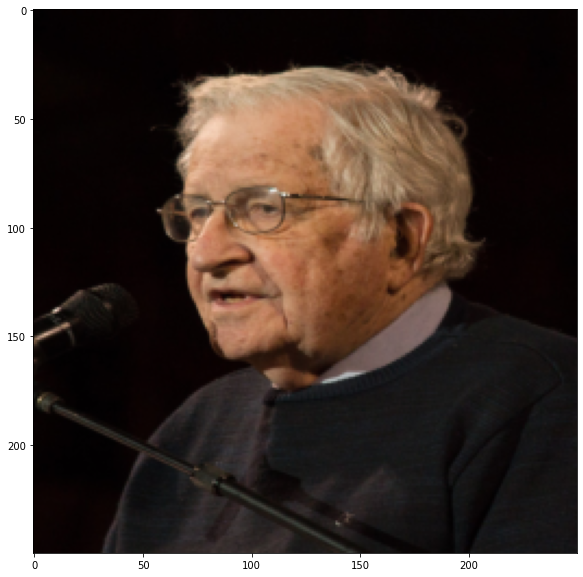

In [21]:
plt.figure(figsize=(10, 10))
plt.imshow(img_a1)

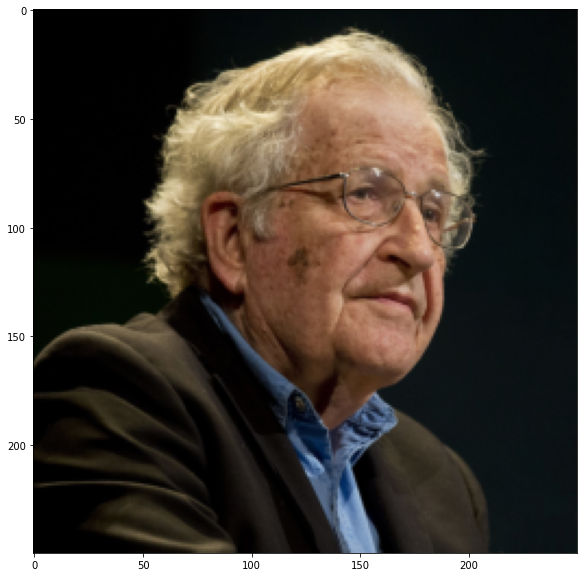

In [24]:
plt.figure(figsize=(10, 10))
plt.imshow(img_a2)

Чарльз Филлмор

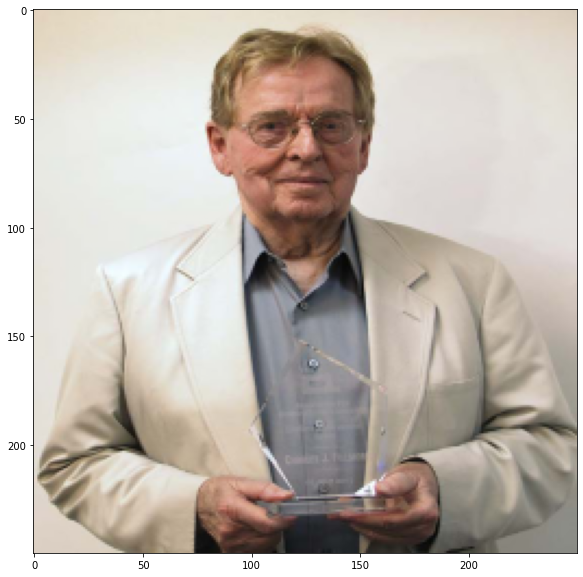

In [25]:
plt.figure(figsize=(10, 10))
plt.imshow(img_b1)

In [0]:
new_embs = model(np.stack((img_a1, img_a2, img_b1), axis=0))

Кажется, действительно работает?

In [28]:
def diff(e1, e2):
    return np.sum((e1 - e2)**2) ** 0.5

emb1 = new_embs[0,:]
emb2 = new_embs[1,:]
emb3 = new_embs[2,:]

print('A1 <-> A2: ', diff(emb1, emb2))
print('A2 <-> B1: ', diff(emb2, emb3))
print('A1 <-> B1: ', diff(emb1, emb3))

A1 <-> A2:  20.856854804451807
A2 <-> B1:  79.60983040841282
A1 <-> B1:  80.3977052883041
